Name: Antony Krymski

Username: agk-123

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [32]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

import keras

In [33]:
# import numpy as np
# import matplotlib.pyplot as plt

# def generate_gbm(start_price, mu, sigma, n_steps, dt):
#     prices = [start_price]
#     for _ in range(n_steps):
#         prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal()))
#     return np.array(prices)

# # Parameters
# start_price = 100
# mu = 0.0002  # Drift coefficient
# sigma = 0.01  # Volatility coefficient
# n_steps = 1000
# dt = 1  # Time step

# # Generate GBM prices
# gbm_prices = generate_gbm(start_price, mu, sigma, n_steps, dt)

# # Plot the generated prices
# plt.figure(figsize=(14, 7))
# plt.plot(gbm_prices)
# plt.title('Geometric Brownian Motion - Simulated Stock Prices')
# plt.xlabel('Time Steps')
# plt.ylabel('Price')
# plt.show()


In [34]:
# def generate_random_walk(start_price, n_steps):
#     returns = np.random.normal(0, 1, n_steps)
#     prices = start_price + np.cumsum(returns)
#     return prices

# # Parameters
# start_price = 100
# n_steps = 1_000_000

# # Generate random walk
# random_walk_prices = generate_random_walk(start_price, n_steps)

# # Plot the generated prices
# plt.figure(figsize=(14, 7))
# plt.plot(random_walk_prices)
# plt.title('Random Walk - Simulated Stock Prices')
# plt.xlabel('Time Steps')
# plt.ylabel('Price')
# plt.show()

# Data

In [35]:
df = pd.read_hdf('data/data.h5', 'SPY')
df.index = pd.to_datetime(df.index, unit='s')
df = np.rint(df * 100).astype(np.int32)
df

,Open,High,Low,Close,Volume
Date,,,,,
1998-07-01 09:32:00,738100,738100,737700,737700,25760000
1998-07-01 09:33:00,738400,738600,738100,738100,2440000
1998-07-01 09:34:00,738100,738600,738100,738600,250000
1998-07-01 09:35:00,738300,738300,737900,737900,90000
1998-07-01 09:36:00,738300,738300,738100,738100,300000
...,...,...,...,...,...
2023-03-31 15:55:00,4087600,4093400,4087400,4091800,156284100
2023-03-31 15:56:00,4091900,4093400,4090500,4093200,70754400
2023-03-31 15:57:00,4093300,4094100,4092400,4094000,80362600


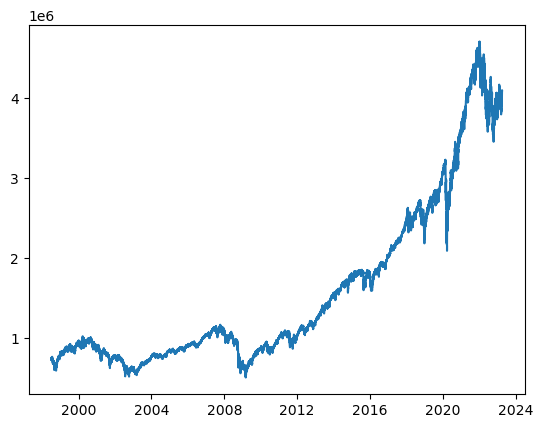

In [36]:
plt.plot(df['Close'])

# Pre-processing

(2399384, 1)


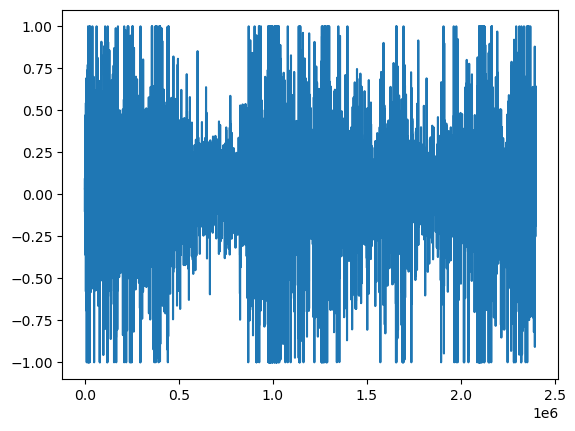

In [37]:
# select features
X = df[['Close']].values 
X = X.astype(np.float32)

# make data stationary using log returns
X = np.log(X)
X = np.diff(X, axis=0)

# remove 0.01% outliers
outliers = np.quantile(np.abs(X), 0.9999)
X = np.clip(X, -outliers, outliers)

max_abs_log_return = np.max(np.abs(X))

# scale
X = X / max_abs_log_return

assert(np.isnan(X).any() == False)

plt.plot(X[:, 0])
print(X.shape)

In [38]:
# import numpy as np
# import pandas as pd

# def inverse_transform_log_returns(log_returns, initial_price):
#     """
#     Inverse transform log returns to reconstruct the original price series.
#     """
#     prices = [initial_price]
#     for i in range(len(log_returns)):
#         next_price = prices[-1] * np.exp(log_returns[i])
#         prices.append(next_price)
#     return np.array(prices[1:])

# # Initial price for reconstruction (you might need to set this based on your data)
# initial_price = df['Close'].iloc[0]  # Or any suitable initial price from your dataset
# # Inverse transform predictions and true values
# y_pred_prices = inverse_transform_log_returns(X, initial_price)

In [39]:
# plt.plot(y_pred_prices[:, 0])

In [40]:
timesteps = 128
features = 1
batch_size = 16
steps = 1
length = len(X) - timesteps - steps
train_index = int(0.8 * length)

x_train = X[:train_index]
x_test = X[train_index:]

y_train = x_train[timesteps::timesteps]
y_test = x_test[timesteps::timesteps]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1919404, 1) (479980, 1)
(14995, 1) (3749, 1)


In [41]:
# window data
def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

x_train = window(x_train, timesteps, timesteps)
x_test = window(x_test, timesteps, timesteps)

print(x_train.shape, x_test.shape)

assert(x_train.shape[0] == y_train.shape[0])

(14995, 128, 1) (3749, 128, 1)


# Data Generation

In [42]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.data[idx]
            y_positive = self.data[idx+1]
            
            # base case
            # y_negative = np.zeros_like(y_positive)
            
            # flipping but not well (only do if non stationary data)
            # y_negative = np.max(y_positive) + np.min(y_positive) - y_positive
            
            # make y_negative normal distribution from same range as y_positive
            y_negative = np.random.normal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0])
            y_negative = np.clip(y_negative, -1.0, 1.0)
            y_negative = np.expand_dims(y_negative, -1)
            
            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [43]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

937
x shape: (16, 128, 1), y shape: (16, 128, 1), labels shape: (16, 1)


# Inspecting Windows

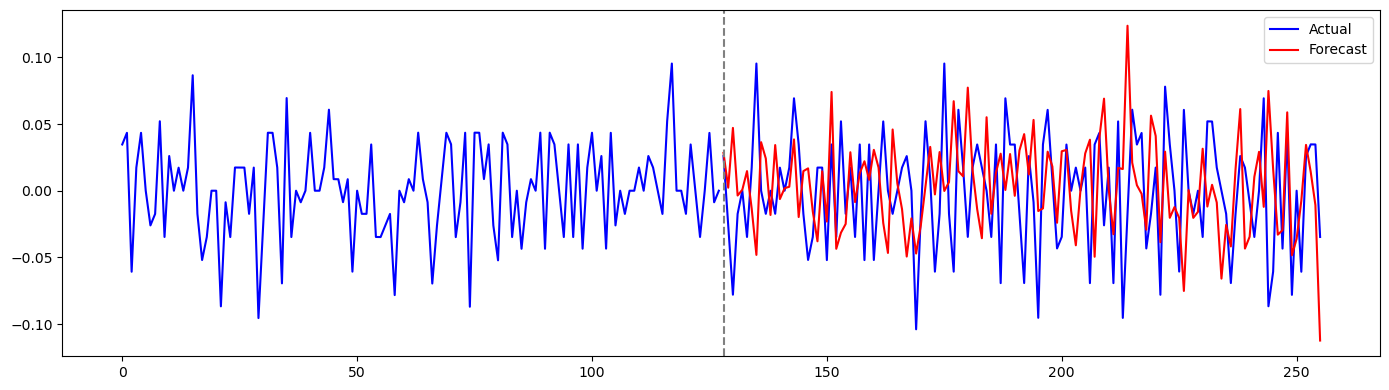

In [44]:
def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(x[0, :, 0], y[0, :, 0], y[1, :, 0])

# Model Architecture

In [45]:
def network_encoder(x, code_size):
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Dense(256, activation='linear')(x)
    x = Dense(128, activation='linear')(x)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    # x = Reshape((-1,1))(x)
    return x

In [46]:
code_size = 32
input_shape = (timesteps, features)

encoder_input = Input(input_shape)
encoder_output = network_encoder(encoder_input, code_size)
encoder_model = Model(encoder_input, encoder_output, name='encoder')
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           256       
                                                                 
 dense (Dense)               (None, 128, 128)          8320      
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                524320    


                                                                 
Total params: 532,896
Trainable params: 532,896
Non-trainable params: 0
_________________________________________________________________


In [47]:
x_input = Input(input_shape)
x_encoded = encoder_model(x_input)

# integrates information along the sequence
x_encoded = (Reshape((-1,1))(x_encoded))
# context = GRU(256, return_sequences=False, name="context")(x_encoded)
context = LSTM(256, return_sequences=False, name="context")(x_encoded)

# predict z-latent from context
preds = Dense(code_size, activation="linear", name="preds")(context)

y_input = Input(input_shape)
y_encoded = encoder_model(y_input)

dot_product = K.sum(y_encoded * preds, axis=-1)
# dot_product = K.batch_dot(y_encoded, preds, axes=1)
dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='contrastive')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "contrastive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 32)           532896      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 32, 1)        0           ['encoder[0][0]']      

In [48]:
from tensorflow.keras.callbacks import Callback

class SaveBestEncoderCallback(Callback):
    def __init__(self, encoder_model, filepath):
        super(SaveBestEncoderCallback, self).__init__()
        self.encoder_model = encoder_model
        self.filepath = filepath
        self.best = 0

    def on_epoch_end(self, epoch, logs=None):
        # Print logs for debugging purposes
        if logs is not None:
            print(f'Logs for epoch {epoch + 1}: {logs}')

        current = logs.get('val_binary_accuracy')  # Use the correct key for validation accuracy
        if current is None:
            return
        
        if current > self.best:
            self.best = current
            self.encoder_model.save(self.filepath)
            print(f'\nEpoch {epoch + 1}: Saving encoder model weights to {self.filepath}')


In [49]:
batch_size = 64
epochs = 50

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

# Define the file path to save the best encoder weights
encoder_weights_path = 'best_encoder_weights_new.h5'

# Create the SaveBestEncoderCallback
save_best_encoder_callback = SaveBestEncoderCallback(
    encoder_model=encoder_model,
    filepath=encoder_weights_path
)


In [ ]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen, callbacks=[save_best_encoder_callback])

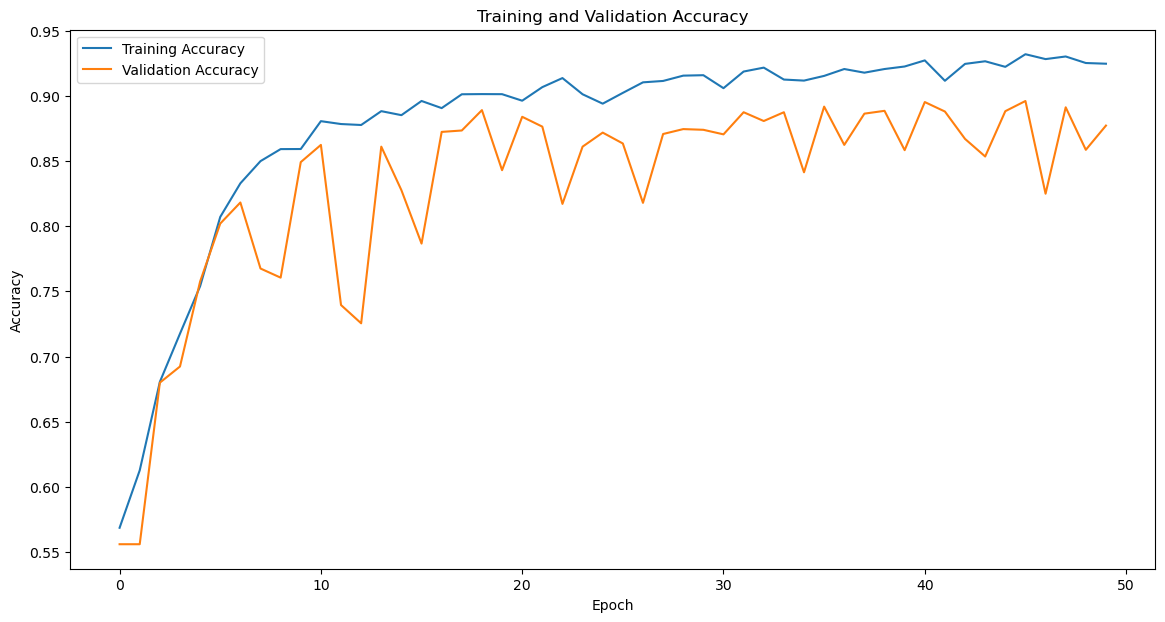

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Downstream Task

### Balance dataset

In [50]:
for i in range(len(x_train)-1):
    y_train[i] = np.sum(x_train[i+1, :, 0])
for i in range(len(x_test)-1):
    y_test[i] = np.sum(x_test[i+1, :, 0])

In [51]:
y_test = np.where(y_test > 0, 1., 0)
y_train = np.where(y_train > 0, 1., 0)

In [52]:
def rebalance(y):    
    labels = np.column_stack((np.unique(y, return_counts=True)))
    labels = labels[~np.isnan(labels).any(axis=1)]
    min_samples = np.min(labels[:, 1]).astype(np.int32)
    idx = []
    for label in labels[:, 0]:
        idx.extend(np.where(y == label)[0][:min_samples])
    return np.array(idx)

idx = rebalance(y_train)
x_train = x_train[idx]
y_train = y_train[idx]

idx = rebalance(y_test)
x_test = x_test[idx]
y_test = y_test[idx]

In [53]:
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

# assert to check if positive and negative indices are correct
assert len(positive_indices) + len(negative_indices) == len(y_test)
# assert to check there is no overlap between positive and negative indices
assert len(set(positive_indices).intersection(negative_indices)) == 0

#  find ratio of class imbalance
positive_ratio = len(positive_indices) / len(y_test)
negative_ratio = len(negative_indices) / len(y_test)
print(f'Positive Ratio: {positive_ratio}, Negative Ratio: {negative_ratio}')

Positive Ratio: 0.5, Negative Ratio: 0.5


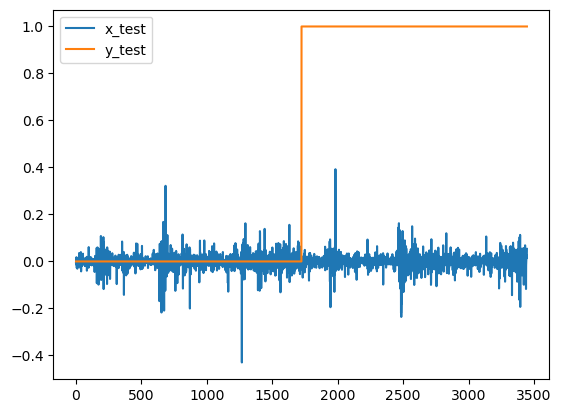

In [54]:
plt.plot(x_test[:, 0, 0])  
plt.plot(y_test[:, 0])
# legend
plt.legend(['x_test', 'y_test'])

In [55]:
# encoder_model = load_model('encoder_30_07_lstm.h5', compile=True)
encoder_model = load_model('best_encoder_weights.h5', compile=True)
encoder_model.trainable = False  # Freeze the encoder model

x_input = Input(input_shape)
x = encoder_model(x_input)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
# x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

forecasting_model = Model(x_input, x)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.05)
forecasting_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
forecasting_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 encoder (Functional)        (None, 32)                532896    
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 535,041
Trainable params: 2,145
Non-trainable p

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# def scheduler(epoch, lr):
#     if epoch % 10 == 0 and epoch != 0:
#         lr = lr * 0.9
#     return lr

# Create callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_ds_04.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
# lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


In [129]:
# Train the model
history = forecasting_model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback]
)

Epoch 1/200
181/184 [============================>.] - ETA: 0s - loss: 0.7664 - binary_accuracy: 0.4972
Epoch 1: val_binary_accuracy improved from -inf to 0.49854, saving model to best_model_ds_04.h5
184/184 [==============================] - 1s 4ms/step - loss: 0.7663 - binary_accuracy: 0.4972 - val_loss: 0.7129 - val_binary_accuracy: 0.4985
Epoch 2/200
183/184 [============================>.] - ETA: 0s - loss: 0.7066 - binary_accuracy: 0.5079
Epoch 2: val_binary_accuracy did not improve from 0.49854
184/184 [==============================] - 1s 4ms/step - loss: 0.7067 - binary_accuracy: 0.5078 - val_loss: 0.7004 - val_binary_accuracy: 0.4944
Epoch 3/200
179/184 [============================>.] - ETA: 0s - loss: 0.6999 - binary_accuracy: 0.5066
Epoch 3: val_binary_accuracy improved from 0.49854 to 0.50049, saving model to best_model_ds_04.h5
184/184 [==============================] - 1s 4ms/step - loss: 0.6997 - binary_accuracy: 0.5068 - val_loss: 0.6989 - val_binary_accuracy: 0.5005


In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

108/108 [==============================] - 0s 1ms/step - loss: 0.7199 - binary_accuracy: 0.5122
Loss: 0.7198576331138611, Accuracy: 0.5121880173683167
108/108 [==============================] - 0s 1ms/step
F1 Score: 0.5311018131101813
108/108 [==============================] - 0s 1ms/step


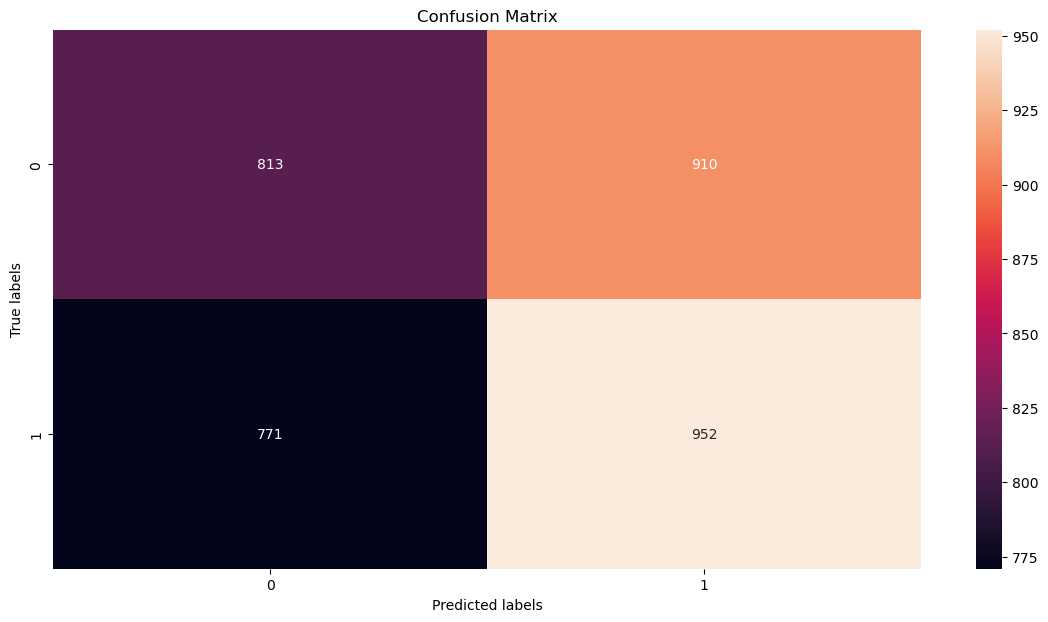

In [58]:
# Load the best model
best_model = load_model('best_model_ds_0525.h5')

# evaluate the best model
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

y_pred = best_model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
f1 = f1_score(y_test, y_pred)

print(f'F1 Score: {f1}')

y_pred = best_model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)

# plot the matrix
plt.figure(figsize=(14, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [154]:
# Print statistics about the log returns
print(f"Min log return: {np.min(X)}")
print(f"Max log return: {np.max(X)}")


Min log return: -1.0
Max log return: 1.0


In [160]:
# Check for NaNs or infs in log returns
print(f"NaNs in log returns: {np.isnan(y_pred).any()}")
print(f"Infs in log returns: {np.isinf(y_pred).any()}")


NaNs in log returns: False
Infs in log returns: False


In [163]:
# Check for floating-point issues
epsilon = np.finfo(float).eps
print(f"Epsilon for floating-point precision: {epsilon}")


Epsilon for floating-point precision: 2.220446049250313e-16


In [162]:
import numpy as np
import pandas as pd

def inverse_transform_log_returns(log_returns, initial_price):
    """
    Inverse transform log returns to reconstruct the original price series.
    """
    prices = [initial_price]
    for i in range(len(log_returns)):
        next_price = prices[-1] * np.exp(log_returns[i])
        prices.append(next_price)
    return np.array(prices[1:])

# Initial price for reconstruction (you might need to set this based on your data)
initial_price = df['Close'].iloc[0]  # Or any suitable initial price from your dataset
# Inverse transform predictions and true values
y_pred_prices = inverse_transform_log_returns(y_pred, initial_price)
# y_true_prices = inverse_transform_log_returns(y_test, initial_price)



/var/folders/k0/x79hb9j52592z6fm_kpxykrr0000gn/T/ipykernel_4317/516682525.py:10: RuntimeWarning: overflow encountered in multiply
  next_price = prices[-1] * np.exp(log_returns[i])


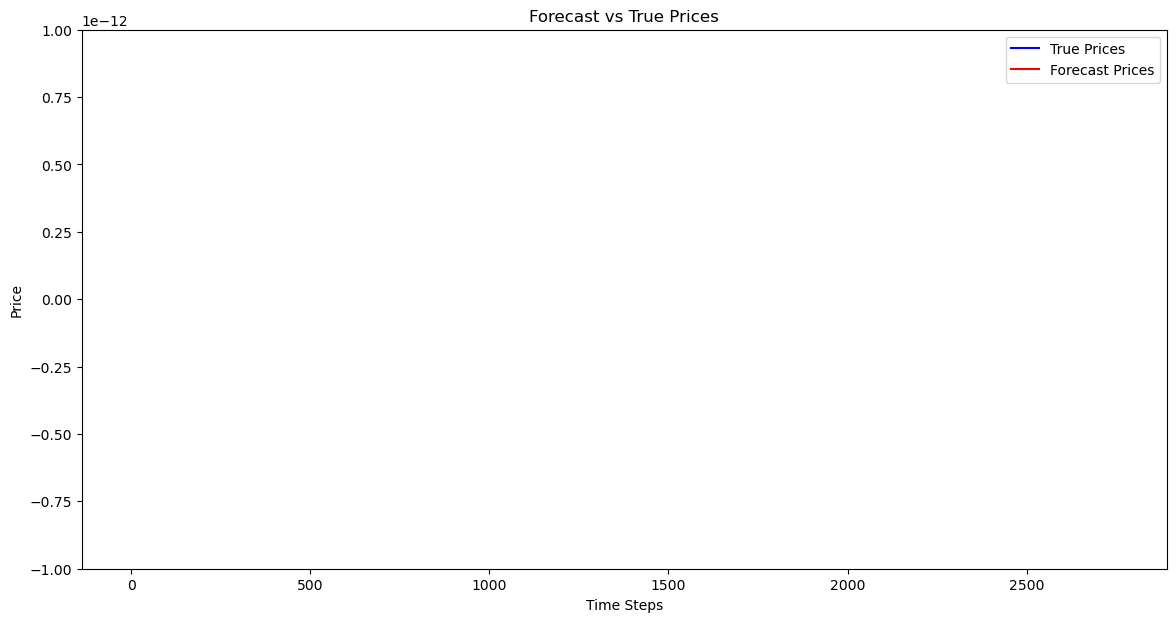

In [150]:
import matplotlib.pyplot as plt

def plot_forecast(true_prices, forecast_prices, title="Forecast vs True Prices"):
    plt.figure(figsize=(14, 7))
    plt.plot(true_prices, label='True Prices', color='blue')
    plt.plot(forecast_prices, label='Forecast Prices', color='red')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plot the results
plot_forecast(y_true_prices, y_pred_prices)


In [40]:
# # round positive values to +1 and negative to -1 
# y_train = np.where(y_train > 0, 1., 0)
# y_test = np.where(y_test > 0, 1., 0)

In [41]:
# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_ds.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

## With Encoder

In [42]:
history = forecasting_model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 0.7522 - binary_accuracy: 0.5076
Epoch 1: val_binary_accuracy improved from -inf to 0.51800, saving model to best_model_ds.h5
235/235 [==============================] - 3s 13ms/step - loss: 0.7522 - binary_accuracy: 0.5076 - val_loss: 0.7196 - val_binary_accuracy: 0.5180
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.7142 - binary_accuracy: 0.5123
Epoch 2: val_binary_accuracy did not improve from 0.51800
235/235 [==============================] - 3s 11ms/step - loss: 0.7142 - binary_accuracy: 0.5123 - val_loss: 0.7118 - val_binary_accuracy: 0.5135
Epoch 3/20
232/235 [============================>.] - ETA: 0s - loss: 0.7101 - binary_accuracy: 0.5164
Epoch 3: val_binary_accuracy did not improve from 0.51800
235/235 [==============================] - 3s 11ms/step - loss: 0.7099 - binary_accuracy: 0.5170 - val_loss: 0.7067 - val_binary_accuracy: 0.5084
Epoch 4/20
231/235 [========================

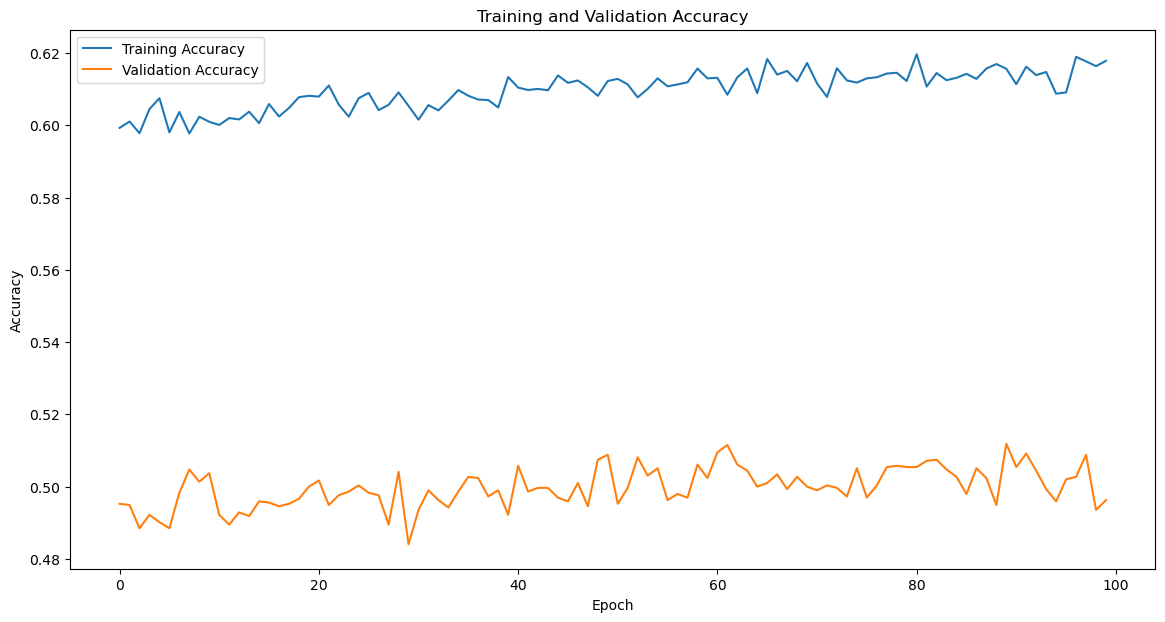

In [99]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Without Encoder

In [49]:
# Define the model without the encoder
x_input = Input(shape=input_shape)
x = Reshape((-1, 1))(x_input)
x = GRU(64, return_sequences=False)(x)
# x = LSTM(256, return_sequences=False, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

forecasting_model = Model(inputs=x_input, outputs=x)
forecasting_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
forecasting_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 reshape_5 (Reshape)         (None, 128, 1)            0         
                                                                 
 gru_4 (GRU)                 (None, 64)                12864     
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0  

In [48]:
# Train the model
forecasting_model.fit(x_train, y_train, epochs=3, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/3
235/235 [==============================] - 8s 27ms/step - loss: 0.6924 - binary_accuracy: 0.5219 - val_loss: 0.6904 - val_binary_accuracy: 0.5404
Epoch 2/3
235/235 [==============================] - 6s 24ms/step - loss: 0.6924 - binary_accuracy: 0.5240 - val_loss: 0.6908 - val_binary_accuracy: 0.5404
Epoch 3/3
235/235 [==============================] - 6s 24ms/step - loss: 0.6922 - binary_accuracy: 0.5238 - val_loss: 0.6909 - val_binary_accuracy: 0.5404
